In [1]:
import os
import sys
import shutil
import subprocess
import numpy as np
from typing import Union, Optional
import pubchempy as pcp
from collections import Counter
import re

from torch_geometric.data import InMemoryDataset, Data
from torch import load, save, tensor
import torch 

from ase.io import read
from ase import Atoms

from sklearn.preprocessing import OneHotEncoder

# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.constants import ADSORBATE_ELEMS, METALS, OHE_ELEMENTS
#from oxides_ml.graph_filters import H_filter, C_filter, fragment_filter, ase_adsorption_filter, is_ring
from oxides_ml.graph_test import atoms_to_pyg
#from oxides_ml.node_featurizers import get_gcn, get_radical_atoms, get_atom_valence, adsorbate_node_featurizer, get_magnetization
from oxides_ml.graph_tools import graph_plotter

def pyg_dataset_id(vasp_directory: str, 
                   graph_params: dict,
                   initial_state: bool,
                   augment: bool) -> str:
    """
    Return dataset identifier based on the graph conversion settings.
    
    Args:
        vasp_directory (str): Path to the directory containing VASP simulation files.
        graph_params (dict): Dictionary containing the information for the graph generation 
                             in the format:
                            {"structure": {"tolerance": float, "scaling_factor": float, "second_order": int},
                             "features": {"encoder": OneHotEncoder, "adsorbate": bool, "ring": bool, "aromatic": bool, "radical": bool, "valence": bool, "facet": bool}}
    Returns:
        dataset_id (str): PyG dataset identifier.
    """
    # Extract directory name as ID
    id = os.path.basename(os.path.abspath(vasp_directory))

    # Extract graph structure conversion params
    structure_params = graph_params["structure"]
    tolerance = str(structure_params["tolerance"]).replace(".", "")
    scaling_factor = str(structure_params["scaling_factor"]).replace(".", "")
    second_order_nn = str(structure_params["second_order"])
    
    # Extract node features parameters
    features_params = graph_params["features"]
    adsorbate = str(features_params["adsorbate"])
    radical = str(features_params["radical"])
    valence = str(features_params["valence"])
    gcn = str(features_params["gcn"])
    mag = str(features_params["magnetization"])
    target = graph_params["target"]
    state_tag = "initial" if initial_state == True else "relaxed"
    augment_tag = "True" if augment == True else "False"
    
    # Generate dataset ID
    dataset_id = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
        id, target, tolerance, scaling_factor, second_order_nn, 
        adsorbate, radical, valence, gcn, mag, state_tag, augment_tag
    )
    
    return dataset_id

# Function to get the parent directory
def get_parent_dir(path, levels=1):
    for _ in range(levels):
        path = os.path.dirname(path)
    return path

def extract_ispin(incar_path: str):
    """
    Extract the ISPIN value from the VASP INCAR file.

    Args:
        incar_path (str): Path to the INCAR file.

    Returns:
        int or None: Extracted ISPIN value (1 or 2), or None if not found.
    """
    try:
        with open(incar_path, "r") as file:
            for line in file:
                if "ISPIN" in line:
                    parts = line.split("=")
                    if len(parts) > 1:
                        return int(parts[1].strip().split()[0])  # Extract first number
    except FileNotFoundError:
        print(f"INCAR file not found: {incar_path}")
    except ValueError:
        print("Error parsing ISPIN value in INCAR.")
    except Exception as e:
        print(f"Error reading INCAR: {e}")
    
    return None

def extract_energy(outcar_path: str):
    """
    Extract total energy from VASP OUTCAR file using grep.

    Args:
        outcar_path (str): Path to the OUTCAR file.

    Returns:
        float or None: Extracted total energy in eV, or None if not found.
    """
    try:
        # Run grep to find lines with "energy(sigma->0)"
        result = subprocess.run(
            ["grep", "energy(sigma->0)", outcar_path],
            capture_output=True,
            text=True,
            check=True
        )

        # Extract the last value from the line
        last_line = result.stdout.strip().split("\n")[-1]  # Get the last occurrence
        energy = float(last_line.split()[-1])  # Extract energy value
        return energy

    except FileNotFoundError:
        print(f"OUTCAR file not found: {outcar_path}")
    except subprocess.CalledProcessError:
        print(f"Pattern 'energy(sigma->0)' not found in {outcar_path}")
    except Exception as e:
        print(f"Error reading OUTCAR: {e}")
    
    return None


# Extract Metadata
def extract_metadata(path: str):
    """
    Extract metadata based on the file path structure.

    Args:
        path (str): The file path of the CONTCAR/POSCAR file.

    Returns:
        dict: Metadata with 'material', 'adsorbate_group', 'adsorbate_name', "total_energy" (DFT-energy), "slab_energy", "adsorbate_energy", and "adsorption_energy".
    """
    parts = path.split(os.sep)

    metadata = {
        "material": None,
        "adsorbate_group": None,
        "adsorbate_name": None,
        "total_energy": None,
        "adsorbate_energy": None,
        "slab_energy": None,
        "adsorption_energy": None,
        "facet": None,
        "type": None,
        "spin_polarization": None,
        #"adsorbate_indices": [],
        "state_of_origin": "initial" if "POSCAR" in path or "poscar_1" in path else "relaxed"
    }

    if "gas_phase" in parts:
        metadata["material"] = "None"
        metadata["adsorbate_group"] = parts[-3]
        metadata["adsorbate_name"] = parts[-2]

        metadata["total_energy"] = extract_energy(os.path.join(os.path.dirname(path), "OUTCAR"))
        metadata["adsorbate_energy"] = extract_energy(os.path.join(os.path.dirname(path), "OUTCAR"))

        metadata["facet"] = "None"
        metadata["type"] = "gas"
        metadata["spin_polarization"] = extract_ispin(os.path.join(os.path.dirname(path), "INCAR"))

    elif "slab" in parts:
        metadata["material"] = parts[-2]
        metadata["adsorbate_group"] = "None"
        metadata["adsorbate_name"] = "None"

        metadata["total_energy"] = extract_energy(os.path.join(os.path.dirname(path), "OUTCAR"))
        metadata["slab_energy"] = extract_energy(os.path.join(os.path.dirname(path), "OUTCAR"))

        metadata["facet"] = "110"
        metadata["type"] = "slab"
        metadata["spin_polarization"] = extract_ispin(os.path.join(os.path.dirname(path), "INCAR"))

    elif "surface_adsorbates" in parts:
        metadata["material"] = parts[-6]
        metadata["adsorbate_group"] = parts[-5]
        metadata["adsorbate_name"] = parts[-4]

        metadata["total_energy"] = extract_energy(os.path.join(os.path.dirname(path), "OUTCAR"))
        metadata["slab_energy"] = extract_energy(os.path.join(get_parent_dir(path, 7), "slab", metadata["material"], "OUTCAR"))
        metadata["adsorbate_energy"] = extract_energy(os.path.join(get_parent_dir(path, 7), "gas_phase", metadata["adsorbate_group"], metadata["adsorbate_name"], "OUTCAR"))
        metadata["adsorption_energy"] = metadata["total_energy"] - metadata["slab_energy"] - metadata["adsorbate_energy"]

        metadata["facet"] = "110"
        metadata["type"] = "adsorbate"
        metadata["spin_polarization"] = extract_ispin(os.path.join(os.path.dirname(path), "INCAR"))

        #metadata["adsorbate_indices"] = get_adsorbate_indices_from_vasp(path, sum(get_pubchem_formula(metadata["adsorbate_name"]).values()))

    return metadata

# Determine adsorption indices
def get_pubchem_formula(molecule_name):
    compounds = pcp.get_compounds(molecule_name, 'name')
    if compounds:
        pubchem_formula = compounds[0].molecular_formula
        return parse_pubchem_formula(pubchem_formula)
    return None

def parse_pubchem_formula(formula):
    pattern = r'([A-Z][a-z]*)(\d*)'
    parsed = re.findall(pattern, formula)
    atom_counts = {element: int(count) if count else 1 for element, count in parsed}
    return Counter(atom_counts)

def get_adsorbate_indices_from_vasp(filepath, total_adsorbate_atoms):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # POSCAR format: atomic symbols on line 5, atom counts on line 6
    element_symbols = lines[5].split()
    atom_counts = list(map(int, lines[6].split()))
    
    total_atoms = sum(atom_counts)
    adsorbate_start_index = total_atoms - total_adsorbate_atoms
    adsorbate_indices = list(range(adsorbate_start_index, total_atoms))  # 0-based indexing

    return adsorbate_indices

def extract_atom_indices(path: str):
    """
    Extract metadata based on the file path structure.

    Args:
        path (str): The file path of the CONTCAR/POSCAR file.

    Returns:
        dict: Metadata with 'material', 'adsorbate_group', 'adsorbate_name', "total_energy" (DFT-energy), "slab_energy", "adsorbate_energy", and "adsorption_energy".
    """
    parts = path.split(os.sep)
    if "surface_adsorbates" in parts:
        molecule_name = parts[-4]
    elif "gas_phase" in parts:
        molecule_name = parts[-2]
    else:
        molecule_name = "None"

    if "surface_adsorbates" in parts or "gas_phase" in parts:
        parsed_formula = get_pubchem_formula(molecule_name)
        if parsed_formula:
            atom_indices = get_adsorbate_indices_from_vasp(path, sum(parsed_formula.values()))
        else:
            atom_indices = []
    else:
        atom_indices = []

    return atom_indices


class OxidesGraphDataset(InMemoryDataset):

    def __init__(self,
             vasp_directory: str,  # Change input parameter
             graph_dataset_dir: str,
             graph_params: dict[str, Union[dict[str, bool | float], str]],  
             ncores: int=os.cpu_count(), 
             initial_state: bool=False,
             augment: bool=False,
             force_reload: bool=False):

        self.force_reload = force_reload     
        self.initial_state = initial_state
        self.augment = augment
        
        self.dataset_id = pyg_dataset_id(vasp_directory, graph_params, initial_state, augment)
        self.vasp_directory = os.path.abspath(vasp_directory)
        self.root = self.vasp_directory

        self.graph_params = graph_params
        self.graph_structure_params = graph_params["structure"]
        self.node_feats_params = graph_params["features"]
        self.target = graph_params["target"]

        self.output_path = os.path.join(os.path.abspath(graph_dataset_dir), self.dataset_id)

        self.ncores = ncores
        ADSORBATE_ELEMENTS = ["C", "H", "N", "S"]
        self.adsorbate_elems = ADSORBATE_ELEMS
        self.elements_list = ADSORBATE_ELEMS + METALS
        self.ohe_elements = OHE_ELEMENTS

        self.node_feature_list = list(self.ohe_elements.categories_[0])
        self.node_dim = len(self.node_feature_list)
        for key, value in graph_params["features"].items():
            if value:
                self.node_dim += 1
                self.node_feature_list.append(key.upper())

        # **Delete existing dataset if force_reload is enabled**
        if self.force_reload and os.path.exists(self.output_path):
            print(f"Force reloading: deleting existing dataset at {self.output_path}")
            os.remove(self.output_path)

        # Initialize InMemoryDataset
        super().__init__(root=os.path.abspath(graph_dataset_dir))

        # Load dataset if it exists
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = load(self.processed_paths[0], weights_only=False)
        else:
            self.data, self.slices = None, None  # Prevent attribute errors
            

    @property
    def raw_file_names(self): 
        vasp_files = []
        
        for root, _, files in os.walk(self.vasp_directory):  
            if self.initial_state:  
                # Check for "poscar_1" and rename if necessary
                if "poscar_1" in files:  
                    poscar_1_path = os.path.join(root, "poscar_1")
                    poscar_vasp_path = os.path.join(root, "poscar_1.vasp")

                    if not os.path.exists(poscar_vasp_path):
                        shutil.copy(poscar_1_path, poscar_vasp_path)  # Copy instead of rename
                        print(f"Copied {poscar_1_path} -> {poscar_vasp_path}")

                    vasp_files.append(poscar_vasp_path)

                # Add POSCAR if it exists
                elif "POSCAR" in files:  
                    vasp_files.append(os.path.join(root, "POSCAR"))
                
                # If augment=True, also add CONTCAR if available
                if self.augment and "CONTCAR" in files:
                    vasp_files.append(os.path.join(root, "CONTCAR"))

            else:  # Use CONTCAR by default
                if "CONTCAR" in files:
                    vasp_files.append(os.path.join(root, "CONTCAR"))

                # If augment=True, also check for POSCAR/poscar_1 and rename if necessary
                if self.augment:
                    if "poscar_1" in files:  
                        poscar_1_path = os.path.join(root, "poscar_1")
                        poscar_vasp_path = os.path.join(root, "poscar_1.vasp")

                        if not os.path.exists(poscar_vasp_path):
                            shutil.copy(poscar_1_path, poscar_vasp_path)  # Copy instead of rename
                            print(f"Copied {poscar_1_path} -> {poscar_vasp_path}")

                        vasp_files.append(poscar_vasp_path)

                    elif "POSCAR" in files:  
                        vasp_files.append(os.path.join(root, "POSCAR"))

        return vasp_files

    
    @property
    def processed_file_names(self): 
        return self.output_path
    
    def download(self):
        pass

    def process(self):
        """
        Process the VASP directory into PyG-compatible graphs using atoms_to_pyg.
        """
        vasp_files = self.raw_file_names

        # List to store graph data
        data_list = []
        
        for path in vasp_files:
            try:
                graph = self.atoms_to_data(path, self.graph_params)  # Convert to PyG graph
                if graph is not None:
                    data_list.append(graph)
            except Exception as e:
                print(f"Error processing {path}: {e}")

        # Isomorphism test: Removing duplicated data
        # print("Removing duplicated data ...")
        dataset = []
        for graph in data_list:
            if graph is not None:
                is_duplicate, _ = self.is_duplicate(graph, dataset) 
                if not is_duplicate:
                    dataset.append(graph)
        print(f"Graph dataset size: {len(dataset)}")

        if len(dataset) == 0:
            print("No valid graphs found. Exiting process function.")
            return

        # Collate the data into the format required by PyG
        data, slices = self.collate(dataset)

        # Save the processed data
        save((data, slices), self.processed_paths[0])

    def is_duplicate(self, 
                    graph: Data, 
                    graph_list: list[Data], 
                    eps: float=0.01) -> tuple:
            """
            Perform isomorphism test for the input graph before including it in the final dataset.
            Test based on graph formula and energy difference.

            Args:
                graph (Data): Input graph.
                graph_list (list[Data]): graph list against which the input graph is tested.
                eps (float): tolerance value for the energy difference in eV. Default to 0.01 eV.
                grwph: data graph as input
            Returns:
                (bool): Whether the graph passed the isomorphism test.
            """
            
            if len(graph_list) == 0:
                return False, None
            else:
                for rival in graph_list:
                    if graph.type != rival.type:
                        continue
                    if graph.num_edges != rival.num_edges:
                        continue
                    if graph.num_nodes != rival.num_nodes:
                        continue
                    if graph.formula != rival.formula:
                        continue
                    if torch.abs(graph.ads_energy - rival.ads_energy) > eps:
                        continue
                    if graph.facet != rival.facet:
                        continue
                    if graph.material != rival.material:
                        continue
                    if graph.state != rival.state:
                        continue
                    # if graph.bb_type != rival.bb_type: # for TSs
                    #     continue
                    print("Isomorphism detected for {}".format(graph.formula))
                    return True, graph_list.index(rival)
                return False, None

    def atoms_to_data(self, structure: Union[Atoms, str], 
                    graph_params: dict[str, Union[float, int, bool]], 
                    model_elems: list[str] = ADSORBATE_ELEMS + METALS, 
                    calc_type: str='int', 
                    adsorbate_elements =ADSORBATE_ELEMS) -> Data:
        """
        Convert ASE objects to PyG graphs for inference.
        (target values are not included in the Data object).

        Args:
            structure (Atoms): ASE atoms object or POSCAR/CONTCAR file.
            graph_params (dict): Dictionary containing the information for the graph generation in the format:
                                {"tolerance": float, "scaling_factor": float, "metal_hops": int, "second_order_nn": bool}
            model_elems (list): List of chemical elements that can be processed by the model.
            calc_type (str): Type of calculation. "int" for intermediates, "ts" for transition states.
            adsorbate_elements (list): List of adsorbate elements. Default to ["C", "H", "O", "N", "S"].
        Returns:
            graph (Data): PyG Data object.
        """

        
        if isinstance(structure, str):
            path = structure  
            structure = read(structure)
        elif not isinstance(structure, Atoms):
            raise TypeError("Structure must be of type ASE Atoms or POSCAR/CONTCAR file path.")
        
        # Debug statement
        if not isinstance(structure, Atoms):
            print("Structure is not an ASE Atoms object.")
        
        # Get list of elements in the structure
        elements_list = list(set(structure.get_chemical_symbols()))
        if not all(elem in model_elems for elem in elements_list):
            raise ValueError("Not all chemical elements in the structure can be processed by the model.")
        
        # Read graph conversion parameters
        graph_structure_params = graph_params["structure"]
        graph_features_params = graph_params["features"]
        formula = structure.get_chemical_formula()

        # Construct one-hot encoder for elements
        ohe_elements = OneHotEncoder().fit(np.array(model_elems).reshape(-1, 1)) 
        elements_list = list(ohe_elements.categories_[0])
        node_features_list = list(ohe_elements.categories_[0]) 
        
        adsorbate_indices = extract_atom_indices(path)

        # append to node_features_list the key features whose value is True, in uppercase
        for key, value in graph_features_params.items():
            if value:
                node_features_list.append(key.upper())
        graph, surf_atoms, _ = atoms_to_pyg(structure, 
                                            calc_type,
                                            graph_structure_params["tolerance"], 
                                            graph_structure_params["scaling_factor"],
                                            graph_structure_params["second_order"], 
                                            ohe_elements, 
                                            adsorbate_indices)  
        graph.formula = formula
        graph.node_feats = node_features_list

        metadata = extract_metadata(path)

        graph.state = metadata["state_of_origin"]

        graph.material = metadata["material"]
        graph.adsorbate_group = metadata["adsorbate_group"]
        graph.adsorbate_name = metadata["adsorbate_name"]

        graph.facet = metadata["facet"]
        graph.type = metadata["type"]
        graph.spin_polarization = metadata["spin_polarization"]
        
        graph.energy = tensor([metadata["total_energy"]]) if metadata["total_energy"] is not None else tensor([0.0])
        graph.slab_energy = tensor([metadata["slab_energy"]]) if metadata["slab_energy"] is not None else tensor([0.0])
        graph.adsorbate_energy = tensor([metadata["adsorbate_energy"]]) if metadata["adsorbate_energy"] is not None else tensor([0.0])
        graph.ads_energy = tensor([metadata["adsorption_energy"]]) if metadata["adsorption_energy"] is not None else tensor([0.0])
        graph.target = tensor([metadata[self.target]]) if metadata[self.target] is not None else tensor([0.0])

        graph.adsorbate_indices = adsorbate_indices

        # # NODE FEATURIZATION
        # try:
        #     if graph_features_params["adsorbate"]:
        #         graph = adsorbate_node_featurizer(graph, adsorbate_elements)
        #     if graph_features_params["radical"]:
        #         graph = get_radical_atoms(graph, adsorbate_elements)
        #     if graph_features_params["valence"]:
        #         graph = get_atom_valence(graph, adsorbate_elements)
        # if graph_features_params["gcn"]:
        #     graph = get_gcn(graph, structure, adsorbate_elements, surf_atoms)
        #     if graph_features_params["magnetization"]:
        #         graph = get_magnetization(graph)

        #     # for filter in [H_filter, C_filter, fragment_filter]:
        #     for filter in [H_filter, C_filter]:
        #         if not filter(graph, adsorbate_elements):
        #             return None
        #     return graph
        # except:
        #     print("Error in node featurization for {}\n".format(formula))
        #     return None
        
        return graph

/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "second_order": True},
                "features": {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False},
                "target": "adsorption_energy"}

vasp_directory = "/BACKUP/database"
graph_dataset_dir = "/home/tvanhout/oxides_ML/models/test_graph_datasets"

dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params, initial_state=False, force_reload=True, augment=False)

Graph dataset size: 2


Processing...
Done!


In [3]:
for graph in range(len(dataset)):
    print(dataset[graph])

Data(x=[120, 8], edge_index=[2, 1756], edge_attr=[1756, 1], elem=[120], formula='Ir40O80', node_feats=[8], state='relaxed', material='IrO2', adsorbate_group='None', adsorbate_name='None', facet='110', type='slab', spin_polarization=[1], energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1], target=[1], adsorbate_indices=[0])
Data(x=[120, 8], edge_index=[2, 1758], edge_attr=[1758, 1], elem=[120], formula='O80Ru40', node_feats=[8], state='relaxed', material='RuO2', adsorbate_group='None', adsorbate_name='None', facet='110', type='slab', spin_polarization=[1], energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1], target=[1], adsorbate_indices=[0])


In [4]:
for graph in dataset:
    if graph.adsorbate_name == "None":
        print(graph.adsorbate_indices)

[]
[]


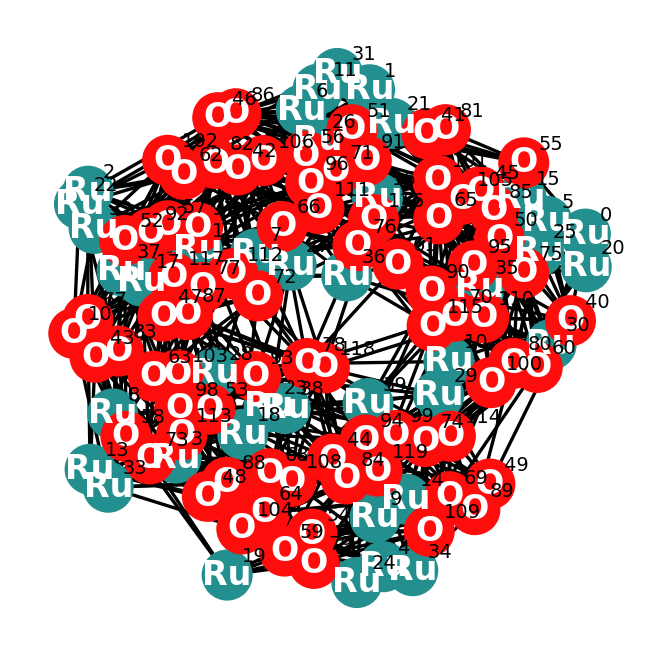

In [5]:
graph_plotter(dataset[1])